### This notebook is extension for data augmentation experiments notebook.

The experiments we used:

**replacement:** real (20%) + tsynth (80%), real (40%) + tsynth (60%), real (60%) + tsynth (40%),  real (80%) + tsynth (20%)

**real only (no tsynth):** real (20%), real (40%), real (60%), real (80%), real (100%)

results include multiple models, I run 5.

for real(embed) we choose 800 images, 400 with lesions and 400 with no lesions, same for the tsynth.

Make sure to run: ```python download_scripts/download_results.py --all``` from ```code/``` directory before running this script.

In [6]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import auc
from utils_plot import process_results, plot_froc_by_density, plot_froc_overall
sys.path.append(os.path.dirname(os.getcwd())) # add upper code/ directory to path 
from utils.eval_utils import dbtex_criteria
import config_global

In [4]:
root_dir_repl = config_global.dir_global + '/data/results/DBT/'
scenario_auc_ = ["real/real20","repl/real20_and_synth80", "real/real100", 
                "real/real40","repl/real40_and_synth60", "real/real100",
                "real/real60","repl/real60_and_synth40", "real/real100", 
                "real/real80","repl/real80_and_synth20", "real/real100"]


labels_auc = {"real/real20":"20:0","repl/real20_and_synth80":"20:80","real/real100":"100:0", 
              "real/real40":"40:0","repl/real40_and_synth60":"40:60","real/real100":"100:0", 
              "real/real60":"60:0","repl/real60_and_synth40":"60:40","real/real100":"100:0", 
              "real/real80":"80:0","repl/real80_and_synth20":"80:20","real/real100":"100:0"  }


scenario_auc = {}
num_readers = 5 
avg_fpr = np.linspace(0, 5, 100)

for scenario in scenario_auc_:
    tpr_all = []
    for reader_id in range(1,num_readers + 1):
        path = f'{root_dir_repl}/{scenario}/{reader_id}/result.csv'
        tpr_interp = process_results(
            file_path=path,
            criteria=dbtex_criteria,
            avg_fpr=avg_fpr,
            use_precision=False,
            filter_dict=None
        )
        tpr_all.append(tpr_interp)
    
    tpr_all = np.array(tpr_all)
    
    tpr_mean = np.mean(tpr_all, axis=0)
    
    auc_value = auc(avg_fpr, tpr_mean)
    scenario_auc[labels_auc[scenario]] = auc_value

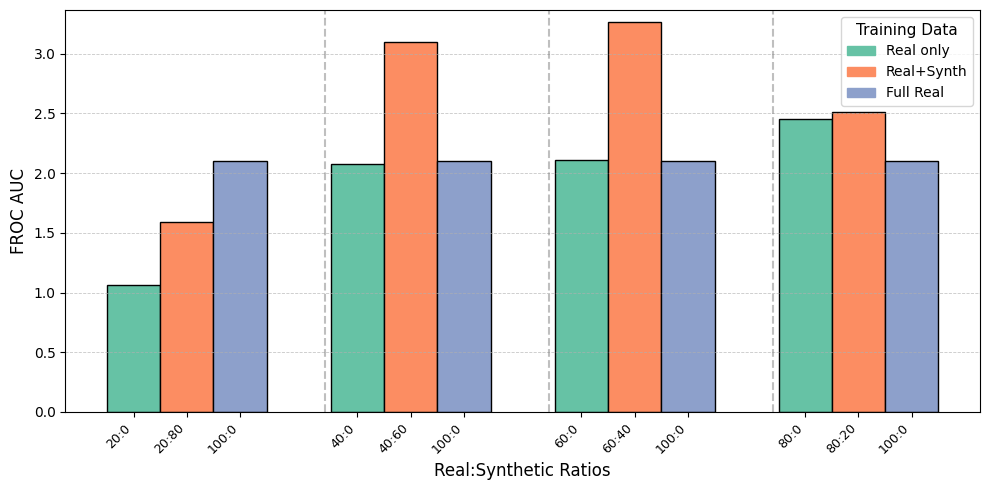

In [5]:
group_labels = ['20', '40', '60', '80']
bar_labels = ['Real only', 'Real+Synth', 'Full Real']
group_data = [
    ['20:0', '20:80', '100:0'],
    ['40:0', '40:60', '100:0'],
    ['60:0', '60:40', '100:0'],
    ['80:0', '80:20', '100:0'],
]

# Collect AUC values per group
group_aucs = [[scenario_auc[label] for label in group] for group in group_data]

# Flatten the data for plotting
flat_aucs = [auc for group in group_aucs for auc in group]
flat_labels = [label for group in group_data for label in group]

# Bar plot settings
n_groups = len(group_data)
n_bars = len(bar_labels)
bar_width = 0.25
group_spacing = 0.3

# Compute bar positions
bar_positions = []
for group_index in range(n_groups):
    group_center = group_index * (n_bars * bar_width + group_spacing)
    for bar_index in range(n_bars):
        pos = group_center + bar_index * bar_width
        bar_positions.append(pos)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
colors = sns.color_palette("Set2", n_colors=3)

for i, (pos, auc) in enumerate(zip(bar_positions, flat_aucs)):
    color_idx = i % n_bars  # cycle through 3 types: real, synth, full
    ax.bar(pos, auc, bar_width, color=colors[color_idx], edgecolor='black')

# X-axis settings
ax.set_xticks(bar_positions)
ax.set_xticklabels(flat_labels, rotation=45, ha='right', fontsize=9)

# Labels and title
ax.set_ylabel('FROC AUC', fontsize=12)
ax.set_xlabel('Real:Synthetic Ratios', fontsize=12)
#ax.set_title('Comparison of FROC AUC across Real/Synthetic Ratios', fontsize=14)

# Optional: group divider lines
for g in range(1, n_groups):
    divider_x = g * (n_bars * bar_width + group_spacing) - group_spacing / 2
    ax.axvline(x=divider_x, color='gray', linestyle='--', alpha=0.5)

# Y-axis limit and grid
ax.set_ylim(0, max(flat_aucs) + 0.1)
ax.grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.7)

# Custom legend
legend_patches = [plt.Rectangle((0, 0), 1, 1, color=colors[i], label=bar_labels[i]) for i in range(n_bars)]
ax.legend(handles=legend_patches, title='Training Data', fontsize=10, title_fontsize=11)

# plt.savefig("froc_auc_barplot_grouped.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()